In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

In [2]:
df

,Unnamed: 0,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,...,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,...,[1.9371510e-07 1.2311488e-02 1.1168750e-02 ......,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448
1,1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,...,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352
2,2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,...,[2.4959445e-07 1.2348385e-02 1.0678725e-02 ......,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352
3,3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,...,[1.1920929e-07 1.2154797e-02 1.6620804e-02 ......,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064
4,4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,...,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,2447,song,fearful,normal,dogs,2nd,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.049500,...,[0. 0.0075674 0.10963831 ... 0.001763...,[0. 0.0075674 0.10963818 ... 0.000290...,0,2880,4888,5208,8160,10080,12096,15112
2448,2448,song,fearful,strong,kids,1st,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.225167,...,[5.9604645e-07 1.4981434e-01 1.9193758e-01 ......,[5.9604645e-07 1.4981428e-01 1.9193728e-01 ......,0,3416,5288,7168,8080,9224,10992,13488
2449,2449,song,fearful,strong,kids,2nd,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.187500,...,[1.0132790e-06 7.4183710e-02 4.1389372e-02 ......,[1.0132790e-06 7.4183673e-02 4.1389298e-02 ......,0,3456,5232,6808,7384,8512,9936,12656
2450,2450,song,fearful,strong,dogs,1st,actor_24,../dataset/Audio_Song_Actors_01-24/Actor_24/03...,F,1.052500,...,[1.04308128e-06 1.24344155e-01 1.12900026e-01 ...,[1.0430813e-06 1.2434411e-01 1.1289983e-01 ......,0,2176,4112,5208,7032,8792,10344,13040


## Short-time Fourier transform

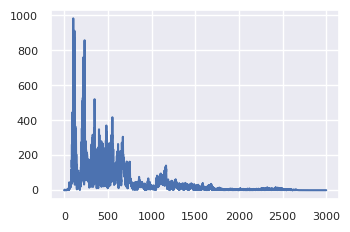

In [3]:
from scipy.fft import fft, ifft, fftfreq

signal = traces["clean_trace"][6]
signal = signal[~np.isnan(signal)]

N, T = len(signal), 1.0/SAMPLING_RATE

spectrum = np.abs(fft(signal)[:N//2])
freqs = fftfreq(N, T)[:N//2]

plt.plot(freqs, spectrum)

Audio split in 50 windows
Each window is 42.33 millisec long
Max frequency is 15.0 kHz
127


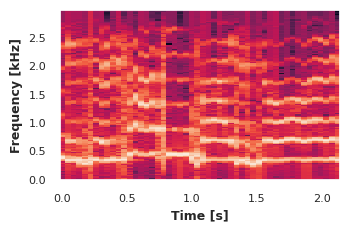

In [94]:
track_index = 1500
signal = traces["clean_trace"][track_index]
signal = signal[~np.isnan(signal)]

M, N, T = 50, len(signal), 1.0/SAMPLING_RATE

windows = np.array_split(signal, M)
winlen = np.min([len(w) for w in windows])

print(f"Audio split in {len(windows)} windows")
print(f"Each window is {winlen/SAMPLING_RATE*1e3:.2f} millisec long")
print(f"Max frequency is {np.max(freqs)*1e-3:.1f} kHz")

STFT = np.zeros((winlen//2, M))

for i, part in enumerate(windows):
    regularized_window = np.hamming(len(part))*part
    window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
    STFT[:winlen//2, i] = np.log(window_spectrum/np.sum(window_spectrum))
    
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]*1e-3
print(winlen//2)
TT, FF = np.meshgrid(TT, FF)    
plt.pcolormesh(TT.T, FF.T, STFT.T)

plt.grid(ls="")
# plt.axis("off")
plt.xlabel("Time [s]");
plt.ylabel("Frequency [kHz]");
# plt.title(f"{df.sex[track_index]} {df.vocal_channel[track_index]} STFT");
plt.savefig('../images/fourier_STFT.pdf')

## Spectral enhancing


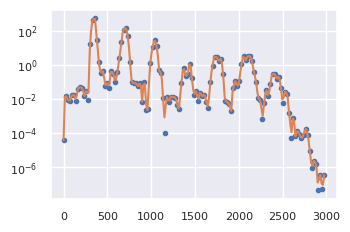

In [59]:
from scipy.interpolate import PchipInterpolator
freqs = fftfreq(winlen, 1.0/SAMPLING_RATE)[:winlen//2]
plt.plot(freqs, window_spectrum, ls="", marker=".")

ffs = np.linspace(0, np.max(freqs), 200)
plt.plot(ffs, PchipInterpolator(freqs, window_spectrum)(ffs))

plt.yscale("log")

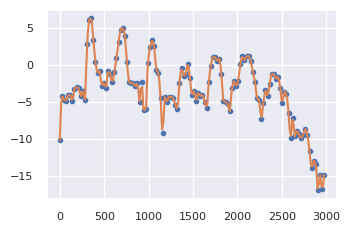

In [60]:
from scipy.interpolate import PchipInterpolator
freqs = fftfreq(winlen, 1.0/SAMPLING_RATE)[:winlen//2]
plt.plot(freqs, np.log(window_spectrum), ls="", marker=".")

ffs = np.linspace(0, np.max(freqs), 200)
plt.plot(ffs, PchipInterpolator(freqs, np.log(window_spectrum))(ffs))

## Spectral statistics timeseries

Since the stft returns a matrix (bad), It is possible to extract a statictical feature from the spectrum of each window, such as the spectral centroid

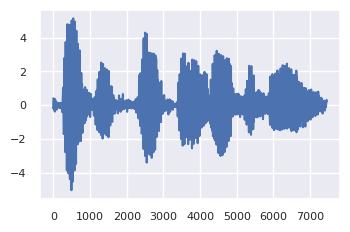

In [5]:
plt.plot(traces["clean_trace"][0])

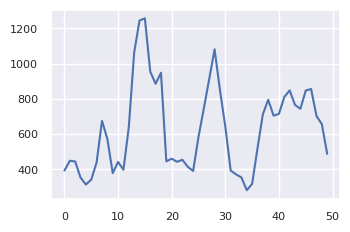

In [6]:
stft_centroid = np.zeros(M)
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]

for i in range(M):
    # get a distribution from STFT
    energy_density = np.exp(STFT[:, i]) - np.min(np.exp(STFT[:, i])) # offsets the minimum to be zero
    energy_density /= np.sum(energy_density)         # normalizes
#     plt.plot(FF, energy_density)

    # gets weighted mean
    stft_centroid[i] = np.sum(FF*energy_density)
    
plt.plot(stft_centroid)

## For the full dataset

Since the tracks have different length, the fourier coefficients have different length.
What is possible to do is to bin the spectrum in a range of freqs and then sum the squares (mean energy).

554
554


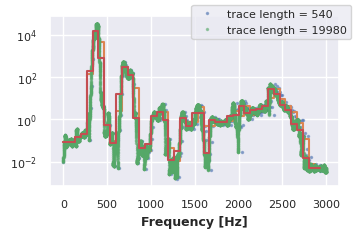

In [122]:
def bin_spectral_energy(spectrum_energy, n_bins, max_freq, sampling_rate=SAMPLING_RATE, plot_check=False):
    if len(spectrum_energy) < n_bins:
        raise ValueError(f"too few frequencies to bin (spectrum has {len(spectrum_energy)})")
    
    T = 1.0/sampling_rate
    
    # Removes higher-pitch part that makes bins unequal
    ss = spectrum_energy[:len(spectrum_energy) - (len(spectrum_energy)%n_bins) ]
    ffs = fftfreq(2*len(ss), T)[:len(ss)]

    ff_bin_edges = np.linspace(0, max_freq, n_bins + 1, endpoint=True)
    
    binned_energies = np.zeros(n_bins)
    for i in range(n_bins):
        binned_energies[i] = np.mean(ss[(ffs >= ff_bin_edges[i])&(ffs < ff_bin_edges[i+1])] )
    
    if plot_check:
        plt.plot(ffs, ss, ls="", marker=".", ms=3,alpha=0.5, label=f"trace length = {2*len(ss)}")
        plt.step(ff_bin_edges[:-1],binned_energies, where="post")
        plt.yscale("log")
        plt.xlabel("Frequency [Hz]")
    return binned_energies

# Test track
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
test_track_index = 1500
signal = traces["clean_trace"][test_track_index]
signal = signal[~np.isnan(signal)]

part = np.array_split(signal, 23)[0]
regularized_window = np.hamming(len(part))*part
window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2
print(len(part))
u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

# Comparison
test_track_index = 1500
signal = traces["clean_trace"][test_track_index]
signal = signal[~np.isnan(signal)]

part = np.array_split(signal, 23)[0]
regularized_window = np.hamming(len(part))*part
window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2

real_freqs = np.linspace(0,1, len(window_spectrum))
fake_freqs = np.linspace(0,1, 10000)
window_spectrum = PchipInterpolator(real_freqs, window_spectrum)(fake_freqs)

print(len(part))
u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

plt.gcf().legend()
plt.savefig("../images/fourier_binning.pdf")

## Test on enhancing spectral resolution

Text(0.5, 1.0, 'shortest is 2000')

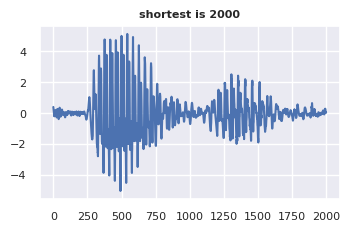

In [62]:
shortest_id = np.argmin([len(_) for _ in traces["clean_trace"]])
X = traces["clean_trace"][shortest_id]
X = X[~np.isnan(X)]

X = X[:2000]

plt.plot(X)
plt.title(f"shortest is {len(X)}")

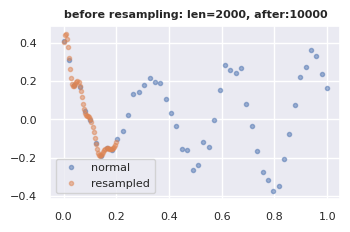

In [63]:
# use resample from librosa to augment data

from librosa import resample

X_resampled = resample(X, orig_sr=SAMPLING_RATE, target_sr=SAMPLING_RATE*5)

t = np.linspace(0,1, 50)
plt.plot(t, X[:50], label="normal", ls="", marker=".",alpha=0.5)
plt.plot(t/5, X_resampled[:50], label="resampled", ls="", marker=".", alpha=0.5)
plt.legend()

plt.title(f"before resampling: len={len(X)}, after:{len(X_resampled)}")

display(Audio(X, rate=SAMPLING_RATE))
display(Audio(X_resampled, rate=5*SAMPLING_RATE))

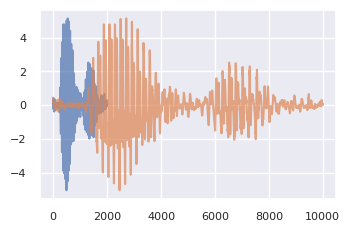

In [64]:
plt.plot(X,alpha=0.7)
plt.plot(X_resampled, alpha=0.7)

frequency density: 0.667334000667334 points/Hz
frequency density if max_freq is 3kHz: 0.6666666666666666

frequency density: 0.6668000266720011 points/Hz
frequency density if max_freq is 3kHz: 3.3333333333333335



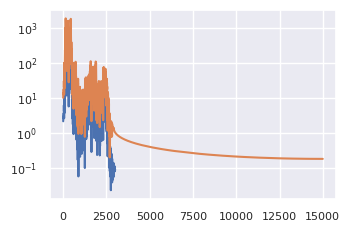

In [65]:
### Check fourier
for signal, sr in zip([X, X_resampled],[SAMPLING_RATE, 5*SAMPLING_RATE]):
    N, T = len(signal), 1.0/sr
    signal_f = np.abs(fft(signal)[:N//2])
    freqs = fftfreq(N,T)[:N//2]
    plt.plot(freqs, signal_f)
    print(f"frequency density: {N/freqs[-1]} points/Hz")
    print(f"frequency density if max_freq is 3kHz: {N/3000}")
    print()
plt.yscale("log")

frequency density: 0.667334000667334 points/Hz
frequency density if max_freq is 3kHz: 0.6666666666666666

frequency density: 0.6668000266720011 points/Hz
frequency density if max_freq is 3kHz: 3.3333333333333335



Text(0.5, 0, 'frequency [Hz]')

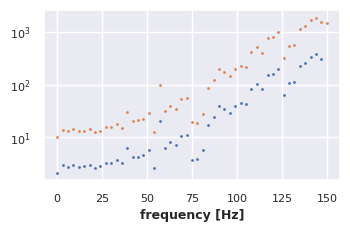

In [66]:
### Check fourier
for signal, sr in zip([X, X_resampled],[SAMPLING_RATE, 5*SAMPLING_RATE]):
    N, T = len(signal), 1.0/sr
    signal_f = np.abs(fft(signal)[:N//2])
    freqs = fftfreq(N,T)[:N//2]
    
    mask = freqs < 150
    
    plt.plot(freqs[mask], signal_f[mask], ls="", marker=".", ms=2)
    print(f"frequency density: {N/freqs[-1]} points/Hz")
    print(f"frequency density if max_freq is 3kHz: {N/3000}")
    print()
plt.yscale("log")
plt.xlabel("frequency [Hz]")

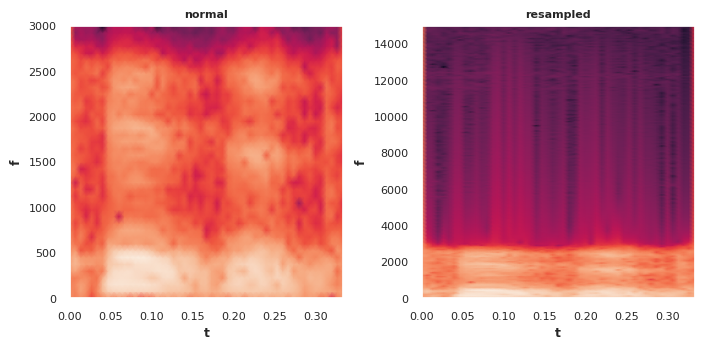

In [146]:
### Check fourier density for windows
from scipy.signal import stft

fig, axes = plt.subplots(1,2, figsize=default_style.FULLSIZE_FIGURE)
for signal, sr, ax, title in zip([X, X_resampled],[SAMPLING_RATE, 5*SAMPLING_RATE], axes, ["normal", "resampled"]):
    f, t, STFT = stft(signal, nperseg=len(signal)//25, fs=sr)
    STFT = 2*np.log(np.abs(STFT))
    ax.pcolormesh(t, f, STFT, shading='gouraud')
    ax.set_xlabel("t")
    ax.set_ylabel("f")
    ax.grid(ls="")
    ax.set_title(title)


## Comparison

In [190]:
subsample = traces["clean_trace"].copy()
np.random.shuffle(subsample)
subsample=subsample[:100]

L = 100

In [191]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=None, 
                        n_spectral_bins=None, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
STFT, sc = transf.fit_transform(subsample)

/home/djanloo/Desktop/DM2/TimeSeries/djanloo_fourier.py:105: UserWarning: time bins/spectral bins not specified, setting balanced bins
  warnings.warn("time bins/spectral bins not specified, setting balanced bins")
/home/djanloo/Desktop/DM2/TimeSeries/djanloo_fourier.py:107: UserWarning: time bins: 56,  spectral_bins=56
  warnings.warn(f"time bins: {self.n_time_bins},  spectral_bins={self.n_spectral_bins}")


shortest trace has length 6496
estimated max fourier  bins: 58


Transforming...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]


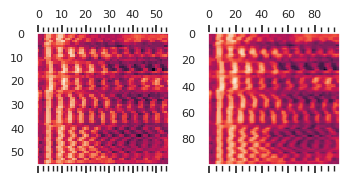

In [192]:
def improve_freq_resolution(stft, final_n_points):
    M = len(stft)
    partial = np.zeros((M, final_n_points))
    for i in range(M):
        partial[i] = PchipInterpolator(np.linspace(0,1,M), stft[i])(np.linspace(0,1, final_n_points))
        
    result = np.zeros((final_n_points, final_n_points))
    
    for i in range(final_n_points):
        result[:,i] = PchipInterpolator(np.linspace(0,1,M), partial[:, i])(np.linspace(0,1, final_n_points))
        
    return result

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.matshow(STFT[0])
ax1.grid(ls="")

ax2.matshow(improve_freq_resolution(STFT[0], 100))
ax2.grid(ls="")


In [193]:
from djanloo_fourier import STFTransformer

padded_transf = STFTransformer(n_time_bins=L, 
                        n_spectral_bins=L, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE,
                        enhancing_method="pad")

# Makes a square STFT
pad_STFT, pad_sc = padded_transf.fit_transform(subsample)

/home/djanloo/Desktop/DM2/TimeSeries/djanloo_fourier.py:114: UserWarning: Number of fourier is max 32.
  warnings.warn(f"Number of fourier is max {self.min_window_length//2}.")
/home/djanloo/Desktop/DM2/TimeSeries/djanloo_fourier.py:116: UserWarning: Activating window padding.
  warnings.warn("Activating window padding.")


estimated max fourier  bins: 32


Transforming...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


In [194]:
from djanloo_fourier import STFTransformer

interp_transf = STFTransformer(n_time_bins=L, 
                        n_spectral_bins=L, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE,
                        enhancing_method="interpolate_spectrum")

# Makes a square STFT
interp_STFT, interp_sc = interp_transf.fit_transform(subsample)

estimated max fourier  bins: 32
spectrum length set to 112


Transforming...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s]


64 59


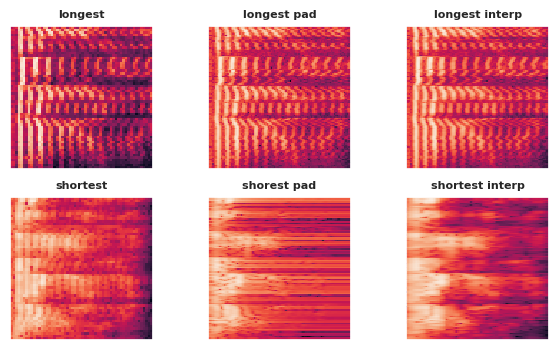

In [195]:
lll = [np.sum(~np.isnan(_)) for _ in subsample]
longest_idx, shortest_idx = np.argmax(lll), np.argmin(lll)
print(longest_idx, shortest_idx)
fig, axes = plt.subplots(2,3, figsize=default_style.FULLSIZE_FIGURE)
axes = axes.flatten()

for who, ax, title in zip([STFT[longest_idx], 
                    pad_STFT[longest_idx],
                    interp_STFT[longest_idx],
                    STFT[shortest_idx], 
                    pad_STFT[shortest_idx],
                    interp_STFT[shortest_idx]], axes, ["longest", "longest pad","longest interp", "shortest", "shorest pad", "shortest interp"]):
    ax.matshow(who)
    ax.grid(ls="")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

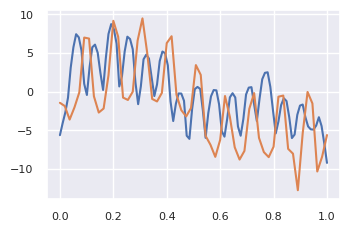

In [196]:
plt.plot(np.linspace(0 ,1, L), interp_STFT[0,15,:])
plt.plot(np.linspace(0,1, transf.n_time_bins), STFT[0,15, :])

(100, 66)
16.66666666666667


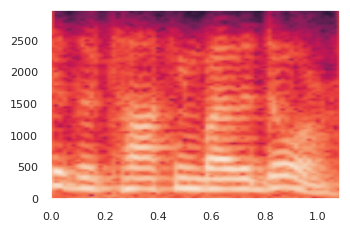

In [277]:
x = subsample[59]
x= x[~np.isnan(x)]

n_spectral_pts = 100

f,t, ssSTFT = stft(x, nperseg=2*n_spectral_pts-1, fs=SAMPLING_RATE)
print(ssSTFT.shape)
print(np.diff(t)[0]*1e3)
plt.pcolormesh(t,f,np.log(np.abs(ssSTFT)), shading="gouraud")
# plt.matshow(np.log(np.abs(ssSTFT)))
plt.grid(ls="")

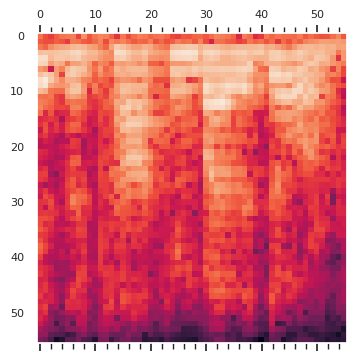

In [209]:
plt.matshow(STFT[59].T);plt.grid(ls="")

## Fixed spectral resolution transformer

In [4]:
from djanloo_fourier import FixedResolutionSTFTransformer

fixedtr = FixedResolutionSTFTransformer(n_spectral_points=100, pad_spectra=False)
STFTs = fixedtr.transform(traces["clean_trace"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:07<00:00, 327.72it/s]


Text(0.5, 1.0, 'song')

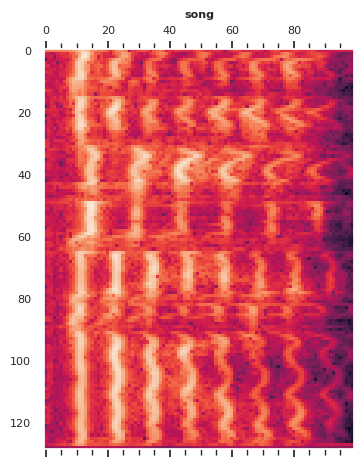

In [5]:
indx=1500
plt.matshow(STFTs[indx])
plt.grid(ls="")
plt.title(df.vocal_channel[indx])